/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/{geography_type}/geographies/{geography}/metrics/{metric}

https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/vaccine_preventable/topics/Measles/geography_types/UKHSA%20Region/geographies/London/metrics/measles_cases_casesByOnsetWeek

Link to Metric:
https://ukhsa-dashboard.data.gov.uk/metrics-documentation/influenza-healthcare-hospital-admission-rate-by-week?returnUrl=%2Fmetrics-documentation%3Fsearch%3D%26page%3D6

Link to API:
https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/vaccine_preventable/topics/Measles/geography_types/UKHSA%20Region/geographies/London/metrics/measles_cases_casesByOnsetWeek




Influenza healthcare hospital admission rate by week

4 UKHSA Super Regions:
    compare by each region, showing each area having a different infection rate



In [3]:
import requests                   #Fabrizio Code (from lectures)
import time

class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # build the path with all the required structure parameters. You do not need to edit this line,
        # parameters will be replaced by the actual values when you instantiate an object of the class!
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=5):
        """ Access the API and download the next page of data. Sets the count
        attribute to the total number of items available for this query. Changing
        filters or page_size will cause get_page to restart from page 1. Rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365); use the default value 
        for debugging your structure and filters. """
        # Check page size is within range
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return [] # we already fetched the last page
        # simple rate limiting to avoid bans
        curr_time=time.time() # Unix time: number of seconds since the Epoch
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # the page parameter is already included in _next_url.
        # This is the API access. Response is a dictionary with various keys.
        # the .json() method decodes the response into Python object (dictionaries,
        # lists; 'null' values are translated as None).
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

    def get_all_pages(self, filters={}, page_size=365):
        """ Access the API and download all available data pages of data. Sets the count
        attribute to the total number of items available for this query. API access rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365), and controls the trade-off
        between time to load a page and number of pages; the default should work well 
        in most cases. The number of items returned should in any case be equal to 
        the count attribute. """
        data=[] # build up all data here
        while True:
            # use get_page to do the job, including the pacing
            next_page=self.get_page(filters, page_size)
            if next_page==[]:
                break # we are done
            data.extend(next_page)
        return data

In [4]:
structure={"theme": "infectious_disease", 
           "sub_theme": "vaccine_preventable",
           "topic": "Measles",
           "geography_type": "UKHSA%20Region",
           "metric": "measles_cases_casesByOnsetWeek"}


In [6]:
import json

structure["geography"]= "London"    #"North West"
api=APIwrapper(**structure)
cases_LN=api.get_all_pages()

with open(structure["geography"]+'.json', "wt") as OUTF:
    json.dump(cases_LN, OUTF)

In [7]:
structure["geography"]= "East Midlands"    #"North West"
api=APIwrapper(**structure)
cases_NW=api.get_all_pages()

with open(structure["geography"]+'.json', "wt") as OUTF:
    json.dump(cases_NW, OUTF)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [10]:
with open("East Midlands.json", "rt") as INFILE:
    East_Midlands=json.load(INFILE)

with open("London.json", "rt") as INFILE:
    London=json.load(INFILE)

In [48]:
data={}
for dataset in [East_Midlands, London]:
    for entry in dataset:
        date=entry['date']
        geography=entry['geography']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][geography]=value

In [50]:
dates=list(data.keys())
dates.sort()

In [51]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [66]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])

index=pd.date_range(startdate, enddate, freq='W-MON')
timeseriesdf=pd.DataFrame(index=index, columns=['London', 'East Midlands'])

In [68]:
# translate the columns to our metrics
structures ={'London': 'London',
          'East Midlands': 'East Midlands'}

for date, entry in data.items(): # each entry is a dictionary with cases, admissions and deaths
    pd_date=parse_date(date) # convert to Pandas format
    for column in ['London', 'East Midlands']: 
        location=structures[column]
        # do not assume all values are there for every date - if a value is not available, insert a 0.0
        value= entry.get(location, 0.0)
        # this is the way you access a specific location in the dataframe - use .loc
        # and put index,column in a single set of [ ]
        timeseriesdf.loc[date, column]=value
            
# fill in any remaining "holes" due to missing dates
timeseriesdf.fillna(0.0, inplace=True)

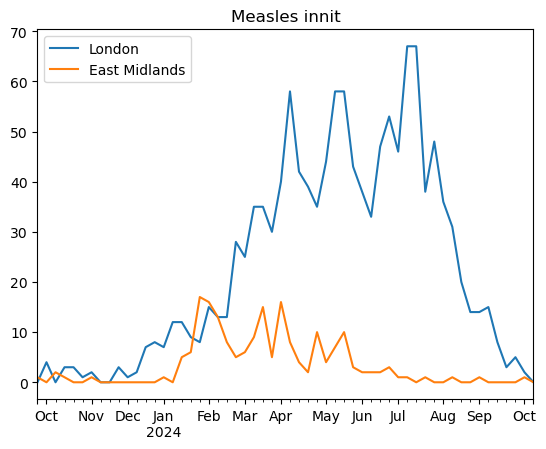

In [74]:
ax=timeseriesdf.plot()
ax.set_title('Measles innit');

In [65]:
timeseriesdf.to_pickle("timeseriesdf.pkl")